<a href="https://colab.research.google.com/github/kg4-ken1ro/mypandas_tutorial_6/blob/main/study_tutorial_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
!pip install optuna # ライブラリーのインストールコマンド
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pylab as plt

from tqdm import tqdm_notebook as tqdm
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
all_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1],
    'min_child_weight': [3, 5, 10],
    'n_estimetors': [10000],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1],
    'random_state': [0],
    'n_jobs': [1],
}

for params in ParameterGrid(all_params):
    break

In [ ]:
def validate(train_x, train_y, params):
    accuracies = []
    feature_importances = []

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    for train_idx, test_idx in cv.split(train_x, train_y):
        trn_x = train_x.iloc[train_idx, :]
        val_x = train_x.iloc[test_idx, :]

        trn_y = train_y.iloc[train_idx]
        val_y = train_y.iloc[test_idx]

        clf = xgb.XGBClassifier(**params)
        clf.fit(trn_x, trn_y)

        pred_y = clf.predict(val_x)
        feature_importances.append(clf.feature_importances_)
        accuracies.append(accuracy_score(val_y, pred_y))
    return accuracies, feature_importances


In [ ]:
def plot_feature_importances(feature_importances, cols):
    df_fimp = pd.DataFrame(feature_importances, columns=cols)
    df_fimp.plot(kind="box", rot=90)
    

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'seed': 0,
        'learning_rate': 0.1,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.8, 1.0),
        'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.8, 1.0),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    accuracies = []
    for train_idx, test_idx in cv.split(train_x, train_y):
        trn_x = train_x.iloc[train_idx, :]
        val_x = train_x.iloc[test_idx, :]

        trn_y = train_y.iloc[train_idx]
        val_y = train_y.iloc[test_idx]

        # main - Predict
        clf = xgb.XGBClassifier(**params)
        clf.fit(trn_x, trn_y)

        pred_y = clf.predict(val_x)
        accuracies.append(accuracy_score(val_y, pred_y))

    return 1.0 - np.mean(accuracies)


In [ ]:
def preprocess_df(df):
    # CabinはこのあとDropするので、コードから削除
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
   
    # 列の削除
    df.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)

    # Sexの01化とEmbarkedのダミー化 
    df["Sex"] = df["Sex"].replace({"male": 0, "female": 1})
    df = pd.get_dummies(df)

    return df


In [ ]:
def predict_df(train_x, train_y, test_x, df_test_raw, path_output="result.csv"):
    params = {'learning_rate': 0.008306052798923729, 'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 0.8210307463506532, 'colsample_bylevel': 0.8061816543590015}
    clf = xgb.XGBClassifier(**params)
    clf.fit(train_x, train_y)
    preds = clf.predict(test_x)
    
    _df = pd.DataFrame()
    _df["PassengerId"] = df_test_raw["PassengerId"]
    _df["Survived"] = preds
    _df.to_csv(path_output, index=False)


In [ ]:
df_train = pd.read_csv("drive/MyDrive/train.csv")

train_y = df_train["Survived"]
train_x = df_train.drop("Survived", axis=1)

train_x = preprocess_df(train_x)

sampler = optuna.samplers.TPESampler(seed=100) # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=1)
params = study.best_trial.params


<ipython-input-6-280910874820>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.8, 1.0),
<ipython-input-6-280910874820>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bylevel': trial.suggest_loguniform('colsample_bylevel', 0.8, 1.0),
<ipython-input-6-280910874820>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.8, 1.0),
<ipython-input-6-280910874820>:10: FutureWarni

0.8148148148148149


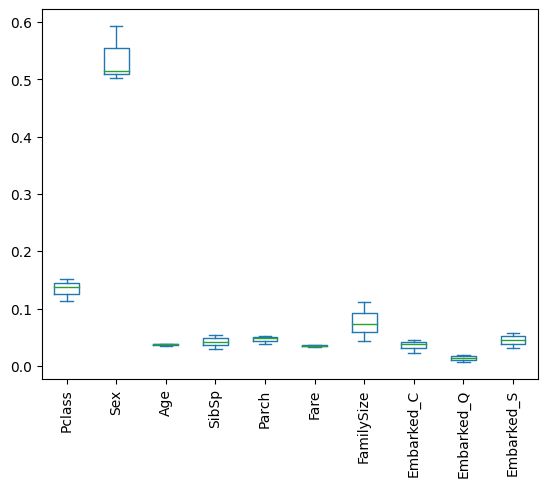

In [ ]:
def main():

  accuracies, feature_importances = validate(train_x, train_y, params)#paramsに書き換え
  print(np.mean(accuracies))
 
  plot_feature_importances(feature_importances, train_x.columns)

  flag_product = True
  if flag_product:
    df_test = pd.read_csv("drive/MyDrive/test.csv")
    df_test_raw = df_test.copy()
    test_x = preprocess_df(df_test)
    predict_df(train_x, train_y, test_x, df_test_raw,"result.csv")

if __name__ == "__main__":
  main()
